In [36]:
!pip install matplotlib


You should consider upgrading via the '/home/nina/Schreibtisch/HCI/Projekt/venv/bin/python -m pip install --upgrade pip' command.


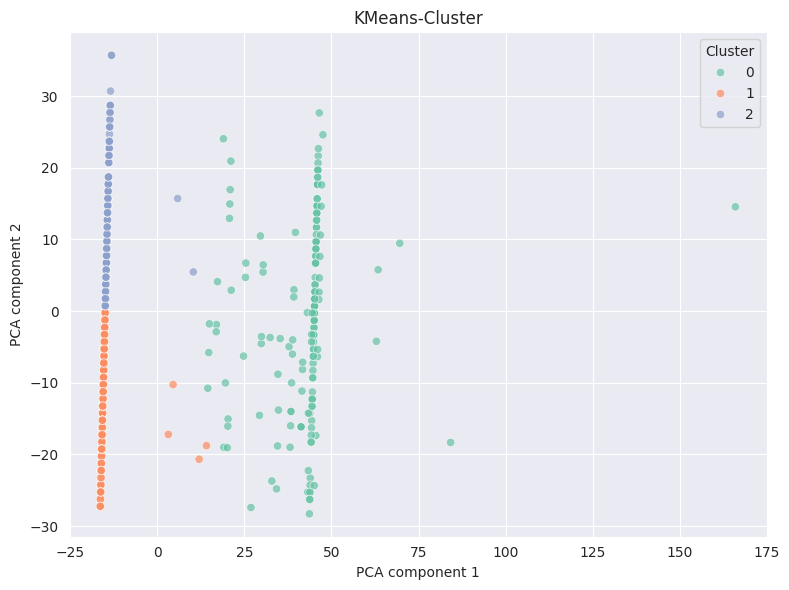

         1:DECEASED  0:LIVING
Cluster                      
0              0.19      0.81
1              0.43      0.57
2              0.12      0.88


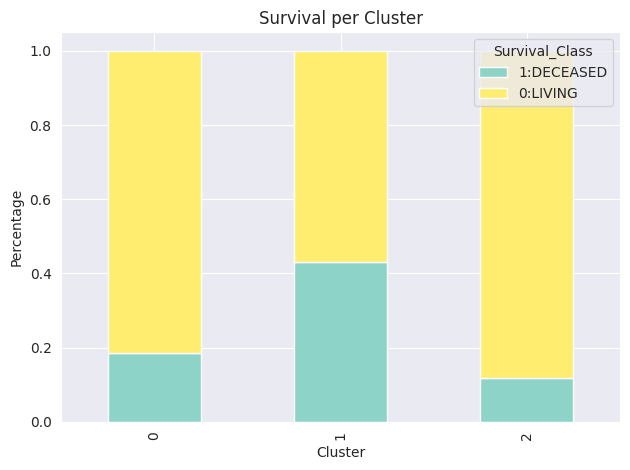

Accuracy: 0.744

 Confusion Matrix:
 [[17 20]
 [14 82]]

 Classification Report:
               precision    recall  f1-score   support

         0.0       0.55      0.46      0.50        37
         1.0       0.80      0.85      0.83        96

    accuracy                           0.74       133
   macro avg       0.68      0.66      0.66       133
weighted avg       0.73      0.74      0.74       133



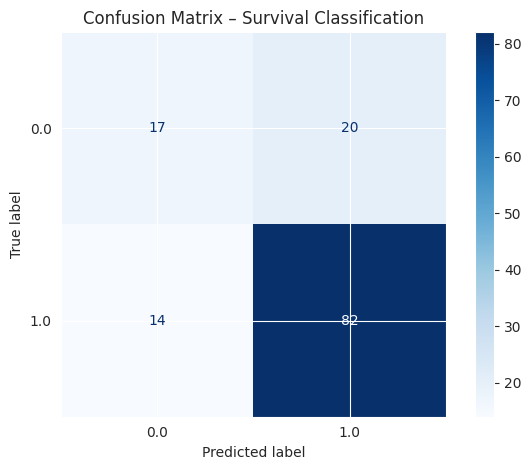

 Logistic Regression Ergebnisse
 Accuracy: 0.752

 Classification Report:
               precision    recall  f1-score   support

         0.0       0.55      0.62      0.58        37
         1.0       0.85      0.80      0.82        96

    accuracy                           0.75       133
   macro avg       0.70      0.71      0.70       133
weighted avg       0.76      0.75      0.76       133


 Confusion Matrix:
 [[23 14]
 [19 77]]


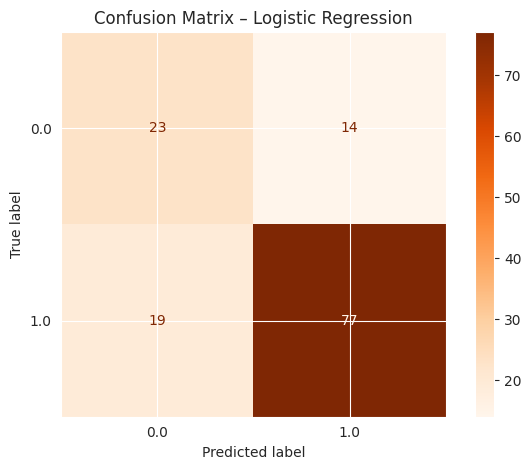

In [1]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split



clinical_data = pd.read_csv("hcai_data-main/difg_glass_clinical_data.tsv", sep="\t")

# extract data from overal survival
def extract_survival_class(val):
    try:
        return int(str(val).split(":")[0])  # nimmt 0 oder 1
    except:
        return np.nan

clinical_data["Survival_Class"] = clinical_data["Overall Survival"].apply(extract_survival_class)

#Survival_Class -> targer 
# 
cols = [
    "Survival_Class", "Age", "Radiation Dose",
    "TMZ Treatment", "Radiotherapy Treatment",
    "Concurrent TMZ Treatment", "Cancer Type", "Cancer Type Detailed"
]
df = clinical_data[cols].copy()

# handle nan values
df = df.dropna(subset=["Survival_Class"])
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Radiation Dose"] = df["Radiation Dose"].fillna(0)


df_encoded = pd.get_dummies(df,
    columns=["TMZ Treatment", "Radiotherapy Treatment", "Concurrent TMZ Treatment",
             "Cancer Type", "Cancer Type Detailed"],
    drop_first=True
)


X = df_encoded.drop(columns=["Survival_Class"]) #feature matrix
y = df_encoded["Survival_Class"] #target

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

X["Cluster"] = clusters

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette="Set2", alpha=0.7)
plt.title("KMeans-Cluster")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


df_analysis = df_encoded.copy()
df_analysis["Cluster"] = clusters
df_analysis["Survival_Class"] = y.values

cluster_summary = df_analysis.groupby("Cluster")["Survival_Class"].value_counts(normalize=True).unstack()
cluster_summary.columns = ["1:DECEASED", "0:LIVING"]
print(cluster_summary.round(2))

cluster_summary.plot(kind="bar", stacked=True, colormap="Set3")
plt.title("Survival per Cluster")
plt.ylabel("Percentage")
plt.xlabel("Cluster")
plt.legend(title="Survival_Class")
plt.tight_layout()
plt.show()


# train - random forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

#train - logic regression
log_model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

# visualize
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix – Survival Classification")
plt.tight_layout()
plt.show()

# f1 score für verstorbene ziemlich gut (0.84)
# f1 Wert für lebende Patienten ausbaufähig (0.52)
# gesamtaccuracy ok
# modell erkennt lebende patienten noch schlecht



print(" Logistic Regression Ergebnisse")
print(" Accuracy:", round(accuracy_score(y_test, y_pred_log), 3))
print("\n Classification Report:\n", classification_report(y_test, y_pred_log))
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

ConfusionMatrixDisplay.from_estimator(log_model, X_test, y_test, cmap='Oranges')
plt.title("Confusion Matrix – Logistic Regression")
plt.tight_layout()
plt.show()
